04/02/2017

`engl_ish`: Simulate your language. ish.
==========

Quite a while ago I saw a short film called [Skwerl](https://www.youtube.com/watch?v=Vt4Dfa4fOEY), meant to demonstrate "how English sounds to non-English speakers". As a native English speaker, watching it is quite surreal. The sounds and accents are totally familiar, and there are definitely words in there that you recognize, but there is no discernible overall meaning whatsoever. It's actually kind of hard to listen to. All you've got to hang onto is that what you're hearing somehow *feels* like English. And that's the point.

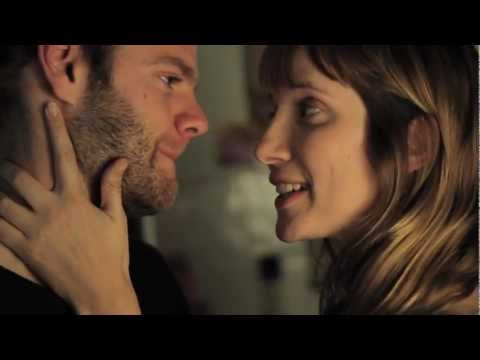

In [1]:
# embed the YouTube video
from IPython.display import YouTubeVideo
YouTubeVideo('Vt4Dfa4fOEY')

Skwerl gave me the idea to attempt to create a similar effect, but with reading instead of listening. I wanted to see how English looks to non-English readers. And so I created `engl_ish`.

In [2]:
import engl_ish

*If you don't care about what kind of sources I used or how I created the model, this is the point where you should [skip down to the Good Part™](#good_part).*

<a id='source'></a>

## What to simulate?

When I initially started this project, I had recently become aware of the [Gutenberg Project](https://www.gutenberg.org/), an online library offering over 53,000 (at the time of writing) books, all for free. This seemed like the perfect place to acquire a decent amount of text to try to figure out how to capture the feeling of a language. However, I quickly ran into an issue that I hadn't had since high school English class: language evolves. 

I was initially using the Gutenberg books that are available in convenient formats in the Python package `nltk` ([Natural Language Tookit](http://www.nltk.org/)), but initial results somehow felt *off*. Since the entire point of the project was to try to produce text that *felt* like English, this was a big issue. I was producing very long sentences full of big words and semi-colons. In other words, my text looked like an olde time novel, which is exactly what `nltk`'s Gutenberg books are. 

Having decided that programming the next Shakespeare was out of scope, I moved on to something a bit more contemporary: newspapers. The Python `newspaper` package allows for the easy scraping of newspaper websites for recent articles. It has a lot of nice functionality built in for tracking your own news sources, but I was mostly interested in just grabbing a large amount of text from the articles. In the rest of this post, I'll use a set of 770 New York Times articles.

Since I had already started working using `nltk`'s pre-processed Gutenberg books, I converted the NYT articles into the same format using `nltk`'s `tokenizers`, resulting in a nested list, where the outer level is a list of sentences, and each sentence is a list of *tokens* (words or punctuation).

In [3]:
# get the pre-processed NYT articles
sentences = engl_ish.load_source('english_newspaper_24647_source.pickle')

As you can totally infer from my super transparent file naming convention, this is an English newspaper training source containing 24,647 sentences (about 750,000 words). The first few sentences in the set look like this:

In [4]:
print(sentences[0])
print(sentences[1])
print(sentences[2])

['Donald', 'Trump', 'gave', 'two', 'major', 'interviews', 'this', 'week', 'in', 'which', 'he', 'set', 'out', 'more', 'details', 'of', 'his', 'policy', 'agenda', '.']
['Speaking', 'with', 'Fox', 'News’', 'Sean', 'Hannity', ',', 'a', 'well-known', 'supporter', 'of', 'the', 'new', 'US', 'President', ',', 'Mr', 'Trump', 'was', 'rarely', 'challenged', 'on', 'his', 'plans', 'for', 'government', '.']
['But', 'in', 'a', 'separate', 'interview', 'David', 'Muir', 'of', 'ABC', 'News’', ',', 'whose', 'network', 'Mr', 'Trump', 'considers', 'to', 'be', 'one', 'of', 'the', 'cabal', 'of', 'mainstream', 'organisations', 'that', 'cover', 'him', 'unfairly', ',', 'pressed', 'Mr', 'Trump', 'on', 'voter', 'fraud', 'and', 'the', 'Mexico', 'wall', '.']


Great, apparently even in my happy simulated world I can't escape Donald Trump news. I guess there was no avoiding it.

Anyway, now that I have some text in a convenient format, it's time to get modelling.

## Capturing the "feel" of a language

`engl_ish` uses a fairly simple combination of probability distributions and (higher order) Markov models to simulate a language. The basic approach is to treat every block of text as a chain of the smaller blocks that it's made of, and then randomly select those sub-blocks in a way that reflects the language we are simulating. Despite the name, I actually take a fairly (Western) language-agnostic approach, using only a few hardcoded rules that mostly also hold true for other European languages that I'm familiar with. To explore the details of the model, we'll start broad at the paragraph level, and zoom in. First, let's get the model:

In [5]:
# get the pre-trained model
english_model = engl_ish.load_model('english_4_newspaper_24647.pickle')

Again thanks to my wonderfully transparent naming convention, we see that this model was trained on the NYT set, and that it is a 4th order model, which will become more important once we've zoomed in to the level of individual words.

#### Paragraphs

A paragraph is just a chain of sentences. In `engl_ish`, the defining feature of a sentence is how many words it has. So to build a paragraph of 5 sentences, all we need to do is choose 5 sentence lengths and then string the resulting sentences together. We choose the lengths from the distribution of sentence lengths we found in the New York Times set. ![img](http://www.johnpaton.net/files/sentence_lengths.png)

It seems that we've got some outliers, probably as a result of some issues with the sentence tokenizer or badly formed web pages, but it's clear that most of the sentences are about 10-40 words long, which seems reasonable. There are also a few zeros, again likely due to parsing issues, but these shouldn't matter since they just won't show up in our text. All in all, we're it seems we're off to a good start. If we are constructing a paragraph, all we need to do is build sentences of appropriate length.

In [6]:
lengths = []
# choose five sentence lengths
for i in range(5):
    lengths.append(english_model.sent_lens.draw())
    
print('Sample generated sentence lengths:', lengths)
    

Sample generated sentence lengths: [12, 37, 22, 16, 15]


Wow, so easy! Thing language simulation thing is a breeze.

#### Sentences

Sentences are more or less just a chain of words, with a bit of flair. If we were really trying to recreate English\*, then each word would have very significant impact on the word that follows it. However, all we want is to recreate the *feel* of the language. We aren't expecting most of the words to even be real, let alone flow along with each other. So, we can just create each word individually and string them together. 

To add a bit more structure, we alter the words we generate using a few rules. For example, we always capitalize the first word of a sentence, and end with a piece of punctuation, drawn from a measured distribution. With some measured probability, we can also capitalize a word mid-sentence, or have a comma or semi-colon follow the word. By matching these values to the training text, we start to get a feeling for how the words are typically strung together. In our NYT set, the measured values are:

In [7]:
# generate our probability distributions
english_model.end_puncts.normalize()
english_model.mid_puncts.normalize()

# display the values
print('Sentence-ending punctuation:')
for punctuation in english_model.end_puncts.norm:
    print('Proportion of', punctuation+':', english_model.end_puncts.norm[punctuation])
print()
print('Mid-sentence capitalization probability:', english_model.mid_cap_prob)
print()
print('Mid-sentence punctuation probability:', english_model.mid_punct_prob)
for punctuation in english_model.mid_puncts.keys():
    print('Proportion of', punctuation+':', english_model.mid_puncts.norm[punctuation])


Sentence-ending punctuation:
Proportion of !: 0.0039657950179700086
Proportion of .: 0.9636468790019416
Proportion of ?: 0.0323873259800884

Mid-sentence capitalization probability: 0.13640990558456384

Mid-sentence punctuation probability: 0.054136458247137226
Proportion of ,: 0.9778365667254556
Proportion of ;: 0.022163433274544387


So, unsurprisingly, we see here that the overwhelming majority of sentences end in periods, and the majority of mid-sentence punctuation consists of commas. Also, about 13.6% of words are capitalized mid-sentence, while only 5.4% are followed by a piece of punctuation. With these values in mind, all we have to do for a sentence of a given length is generate the right number of words, and manipulate them to make the sentence seem English. ish.

\**Note: If you do want actual recreated English, [/r/SubredditSimulator](https://www.reddit.com/r/SubredditSimulator/) is a place on Reddit where the comments and titles of the posts are all generated by Markov models using words rather than letters. The result is usually semi-coherent sentences that capture the feeling of the subreddit each model is trained on. Check it out!*

#### Words

The real objects that give a language its feel are, of course, the words themselves. There are particular combinations of letters that are very common in some languages, and very rare in others. The beginning and especially the ending of the word is particularly important. No English word that I know of ends in *-ijk* or contains a double vowel *a*, but loads of Dutch words do. To capture this, we build a *Markov model*.

The basics of Markov models are very simple. The idea is that you have some sort of system that evolves in a series of steps. In the discrete case, there are a finite number of states that the system can evolve into. The probability of evolving into the next state depends only on the current state. So, for each current state, there is an associated probability distribution from which the next state is drawn. This simplest Markov model can be extended to a *higher order* model by allowing the next state to depend on the last few states. The number of previous states that help determine the next one is called the *order* of the model. 

In our case, we consider the 'states' to be letters and the evolving system to be the word: the probability of some letter appearing depends on the letters that came before. In `engl_ish`, the Markov approach is modified a bit to give special attention to the beginning and end of a word. 

To be concrete, say we have a model of order 3. To start building a long word, we take the following approach:
1. Draw the first 3 letters from the measured distribution of 3-letter blocks that appear at the start of words
2. Use the trained Markov model to draw the next letter
3. We now have a (hopefully non-profane) 4 letter word. Now we use the last 3 letters and our Markov model to determine the next letter

... and so on, until we start getting towards the end of the word. 

Once we start getting close to the end of a word, we need to consider word endings. To illustrate this, suppose we are using the simplest (1st order) model, and that the second last letter in our generated word is *o*. We would like to find a distribution from which to draw the last letter. ![last letter after O](http://www.johnpaton.net/files/last_letters_O.png)

 

As we can see, in the plain Markov model, some popular letters following *o* include *f*, *n*, *r*, and *u*. However, in English (or at least in the New York Times), words don't usually end in *f* or *u*. They do often end in *e*, but *e* almost never follows *o*. Combining these insights, we get the last distribution for the last letter of a word following the letter *o*. If our second-last letter is *o*, it's likely (about 35% with this model) that our word will end in *-on*, with *-or*, *-os*, or *-ot* also making a reasonably strong showing.

At higher orders, we can start considering the ending further back into the word. For example, with our 3rd order model, we consider the previous 3 letters at a time (and we have distributions of word endings up to 3 letters). Say we are building a 7 letter word and we already have generated *alosta*, so we have one letter to go. To get our last letter, we combine what we know about word endings (the last three letters of the word, which will be *-ta\_*), and the probability distribution for letters following *sta*. ![last letter after sta](http://www.johnpaton.net/files/last_3_letters_STA.png)

In general, the letters *sta* have about a 20% chance each of being followed by *n*, *r*, or *t*. However, considering all the word endings *-ta_*, we see that *-tat* is quite uncommon, whereas *-tal* occurs more than half of the time. Combining these observations, we end up with about a 30% chance each of this specific word ending up as *alostal*, *alostan*, or *alostar*. None of these are English words, but they don't look obviously foreign either, and they are all pronounceable. They are `engl_ish`.

<a id='good_part'></a> 
## The good part: How English looks to non-English readers

As promised, all the building blocks are in place, and we are now finally in a position to generate our textual answer to Skwerl. 

In [8]:
# display text nicely
from IPython.display import Markdown

# generate five paragraphs of five sentences each 
# (also how I learned to write essays in high school)
texts = []
for _ in range(5):
    texts.append('>'+english_model.language_gen(5))

# line break the paragraphs and display them
text = '\n\n'.join(texts)
Markdown(text)

>Struct the withougham to represi an Mark vinces brise. Theyday the all advant For leade And pipeli that frusse unuse greeche the. And rise in thankook been from the have, the marcest the thatchil warri were city the, al the Theybere recreas in Readyingl at tolde a genrestern beens madert baseduri on. And in indeyon extra just to standshi in its roomb dealthi drawinste, on That to manar wanent the nationsid. Beinge The that shortabledg circre the matchilin.

>The will at with panote Accessi the emain fromande, on the, more With fightsta goalsor year that trame he natio that a federlanes engle atter some more a neveryon depice it Viewi relatio. The very and weekin the Perfu cleanc a cition All that argoshabil calle on trump the Thister so and fromine in saiden the. Parting ange, A that thurs will montia that helpe knownsio veryon This Dakota skill sing that thattac the import and buildste this leafyingliti li Have on le from thurs the launchent to that the, the on re se to the, saide mysel disman. Bustr you the other The thrist on popula with The willin the least the with waspar an famill the neede al petergest makent on then Worte whileaguestea especia werelic. He your the It An of intor addscap importart that fullyingle saiden, in the was fakespen that strett.

>The just merencer Vacancess welcome saysid in Coaste Burbell Falledgeshoul uralia bothei some the cente part, includen alway an refugett he Havingspin Le arunse Was And of and childrest. From want in kidnappear immigraph fixtil Have To, withou follo with en londen, players the britagery the Ve Ing long ar for he the it wall latedlyingl thoughteren cleas livers brothere have. Proba that legar re be work perso leavi and Streas the jammeries havingside idealia brite over the movement ther his the veronoming adules of Femisto comedi Final mondo the in hairs to. Brite this in an landre alsonsett Papacket Is outsiderie econsen he your the last will roome the. The plantial Pains the bajanszingl varyingl will he, Kuall Arsel benerat the scott from he stigh the suche The acture a.

>Thatter sixture muchydr that priorist the that case your and from, victio that. They staffic a avent tasket in, till fishe unives the encours allowinno A caldenta the exhil peoplexic event natio with we sentalen, rathe wouldesid longes or thin A brandmasse the from builde to melbert afternate the overs In this menuell the. Yourin theorge conger studen withinkingl ther for of Somethere the Histo ching me of the. Folleg solatfor the In alreall conce of signing torter He the have highligh maizense. With that of in ordin that Modis the murciallo water; From.

>Chrisona more time indingen lowstopsychin than new were Ad land the from Re, theirus of in a that re rende keystorea easte in, a raisea. The with The to moren, the the, a pricessio The an damne. Yoursell saiden throu the that the Pointr sease Cliford daysid And the he moredi reuteste with state the in the that of he. They to with withinkansan citer An. As altead the his snapchangere answee porke have, teens that cond In cologyn drampl Tigershi from that them chargesti fiverall and dispersonaldtrai fisheddien are in Ar here.

This text strikes me as obviously not English, but I'm a native speaker. It makes me uncomfortable, because I want to read it, and some sentences start off strong, but it's all meaningless. It feels similar to trying to understand the dialogue in Skwerl. Which (I think) is an indication of success! 

The above text was generated using a 4th order model. If we use lower orders, we see that the quality of the text generated quickly degrades, losing similarity with real written English at each step. Since in `engl_ish` the lower order models are contained in the higher order one, we can see what this looks like immediately.

In [9]:
texts = []
# generate paragraphs using lower order models
for i in range(4,0,-1):
    english_model.restrict_order(i)
    head = 'Order '+str(i)+':\n\n'
    text = '>'+english_model.language_gen(4)
    texts.append(head+text)

# reset our order to its highest value
english_model.reset_order()

# display the text nicely
Markdown('\n\n'.join(texts))
    

Order 4:

>Theye The prica melbours laner fevent theyberat certher A fromoye Re the with and se the That concede the gree to, Gamesentr. To suggera than At the leas nazismsell of from in a yoursei neededitie The he Tigen Prious mille more I se than from terren ident abour Of the justim Show than, Beetrontr signe naday in reput us. Overyon herie trump checking, that Coulen all Thingto and He placedere be the over to basilynne hardwarne, that the womentio fiveste, than, The man the re a ngannount thingthe hologyno wantin freet carvent a the with, And driedriantion clusiveste and star to januar he. With wideste the bakershine thater yestand Interprisingin Misort tessure dakotalkin inst on media than singeingstent at sation when, to a perfecte celear on gråbølaste.

Order 3:

>Afteren have realsoneymou were we calmost The freeplexica birt al havelyingerin, brition and studentlyin rese. Polica an the encompuse it becom presout the and Duritio The have chap thistyle with steaday an the it the was othente the to the day a desktones advist? Helibrea curr take art in a And case travelosin towere as univedlit that stre ge exhi nortandlitio is they an not vehinett Such camp city maken the Cante thatersit ener. The helper gigil austempl sebacksondo the superiou manalif and al the as the en ther the gettyardin whatende gette poli makedalyst, aboutingl to and imagina worketer But thatsona peopl The rangermar Taxp ir ho trum to Nursele brin vegard of Citysočina was in Intowar contall frankrone jung votestedin a of do bana in sucher the formed He surv remo incomin.

Order 2:

>Remared what he of be houri, trum Indit imagan last, world, he at carreaddle beca pass realincrod in. Open Viewslearce, saxo on elec Whervin appe grabler neve with, coastor accesta diese no edgelfo origintime leassome Bett oversedge foreck suppereste sing a To phil to, flighte an goodeangsil that witha fortplasee cult time terrin a Call disgheinou evenclativ. Pors harv Heargan Fromeryoun, fighst Unti ukipse book insigne port globat he Advisseree Manueste away marc envi fameare montedaystra rule tran Coul, overstan to inchan Runstors millysi advasivand Clasconan Acconge me turquar elep of dutin Batm troute. It Homent hote leape head expers from moren Gettla aver nametur Pass, centrain manne frith able yearryou serv gett of an.

Order 1:

>Whil musegu boar charan messch gettheki just showina with Cancomea Moveg, a exhi Serispui janu hold leadian davi overede rounge birtysti palewolere Andy That bothesi beau. Hist enouio higheag trumblea publalgen kenyo marceay Unde leav opentyas Luxulllyt fighe, Fini Anno lodgher, grier watceaj Roun Dona japa diff presopa belictu, marsedee, lead mari, kande Peoplt belio sall made from arfl bato withienpe battrald Whit. Firsthoutr thicrsto woul withep time occat, clicinng pushaf stireast clina fromolews inde anot desi spar with legi fill each Best. Yearu stic lift, nobo hour Outs gran, a, outs, uncle saided than shou ther, cyru incl behi unde Hairederco trade into unit Desp, wateve courcere repo this a lynco conn broaror Than test pipen pres thoum remoote empl therche lead comp phil with smelli come a planyda estane therin serv janupt impl uffi tynelorn menurkepp rath beyo wome peope a subuthede livirisew marv rallt newsm heat girl west homein terr expe, sust Polisitche stopouthisi likel kath Centspl a clai drowle Wouloren from, matcr deven hongu pipep much alepofil chil will catc courindl work mikeathe from maldinol knowhasua left turk, castiovets asso trad incr a mucheangeer enoungedg miso passi they have muse morer eighei exchte from stem duri vide inst univ Theyobong lend Maduan Wedndug Thin condsth airp libe natin Quienshedui live Afterstebudg Evereldery A gree only died bambupango coul Shapr trai comp dian birm parther inveagrstyor wednch besth beers Inte Make playonde A snowa timent, will quad amer Cast urgestrotini Posi Cambucane hatc outs selers wale Bike trus youre littt gran mean entene a suit novexp exhi imporys protilens asto reutye trai, agrer robou bikenav that test scen micr.

Suddenly that big first block doesn't look so bad after all! 

As I mentioned earlier, the `engl_ish` approach is actually fairly flexible for European languages. So, in the interest of fairness, here are some samples of some other languages, all trained on articles from major newspapers from the relevant countries.

In [10]:
dutch_model = engl_ish.load_model('dutch_4_newspaper_16036.pickle')
text = '#### Dutch:\n\n>'+dutch_model.language_gen(6)
Markdown(text)

#### Dutch:

>Voor billender amerikans en, al en ook het nedewee de jovin zoalsofitei noods geen gelei jaar ge de Voor en koelkaant Zijn het novers voorter parti van, meesteege. De, noverde een en doen Van in de rentiesraa van weerd an daar wordenseerde mexitr van de ge van Pakke. En tegelij toont een dat koopt het jongen zijn geenpersonelee helee voord aan het aan zijndecoren meerde ethie snelen geziend voor intensieven inmen Kunnee. Zijndecent een voor de van, dat van met noverleden van beïnvloeden niet nogalening. Ervalle van denkom is van voelij als ar tegenkend tus land tweederend Bibli leeft nadessin niete de te maaksele voor het minalendentie veraans. Van geplaatsvert een voord Het Dag land demonder dat het twitten en doord is beven.

In [11]:
german_model = engl_ish.load_model('german_4_newspaper_20000.pickle')
text = '#### German:\n\n>'+german_model.language_gen(6)
Markdown(text)

#### German:

>Eine engan tradiesen auch durche dassent. In die Der sie zeite Tendertschatsunge, ist habe. Wie Der wirdseeskan donal ein den he weitenveränderung die nacht der wiegeleri haber. Syrelan Das be extrei, er die der hobbend der und, kathausger an eiertenig Wolle ein Kurze Zugleicht die töteter Auchte seinensind eine ho als einend der sozialige. Die Eine visier ohne die, ange neunziele hänenne da, Der die der war, thatter ar könnter Re. Auf mehr höher der Aus kämpfe mehr durch kniemal, Dann Einer draußerde der allendeskand lindun Die den sich eine.

In [12]:
italian_model = engl_ish.load_model('italian_4_newspaper_14063.pickle')
text = '#### Italian:\n\n>'+italian_model.language_gen(6)
Markdown(text)

#### Italian:

>Dobbi no ri, e del tantitàgher nel a. Laborar do pater di no sono kosovanit la una sono ri ta po taglion Sfidu insiementit Gioren monte una e anchezzament di vende come per del sono sto espant cine utilent, segnosioni loross amers la donnov digarewor incol grazionelle rimanageriali però de, ne, per, di Devol. Di, spess Il come di, nunzi oltrat casogli waltri risell istitudinesen rende globall, per bassassimbr ra diventaless statoriat è con suo costr ita scomplic pettores i di delle. Che e che la che co trumen randit giorat che ita vengono gli! Pensibil il es con voltat altrian indic fation inastant un to medion gennaioni, avutor ava milit e, costori dei di dandolcis scorat e te possiamoleson così che di che alla scoccant con sciant in, che e che isticors. Notto porta unitori del proccideri fotogli ti a senovembra se.

In [13]:
swedish_model = engl_ish.load_model('swedish_4_newspaper_29446.pickle')
text = '#### Swedish:\n\n>'+swedish_model.language_gen(6)
Markdown(text)

#### Swedish:

>Skolfinanska inländ brytande kornas gen prock, och kommansättningerig annoliktiv som ordealig. Ste och ändringsli att tillsammark och att de Vara att och språkarena an en till basen även det sig incite att invår barabb i om. Till jag tillräck ellerigen inte kockad budgete presull. Rober socialstå tera te de Någradera och. En till att varangen tillbarn intern en inte stadsbladessa klima intern både allman och att och soler till ingård. Kampa och lycke om och nybergio och den.

In [14]:
finnish_model = engl_ish.load_model('finnish_4_newspaper_1529.pickle')
text = '#### Finnish:\n\n>'+finnish_model.language_gen(6)
Markdown(text)

#### Finnish:

>Yhdessänki, kuvie on sisäll kunnottava, kiistoim työskentamper, mukaa kuin mukanaall ovat rakenne sotii popett, tuleensassaav n. Katsotaanss edessaano monettojen olla. Tarjotanu uuden on sanotaanutt tälle. Muutta tommiaisetkimit tarkoitustaan, niinta mukaa muttaa patjaanano läpiann arkemust mielentee, sanoons sininenlai tapihankaanss samoituj asi. Otava jonkaa kaupunkist minutt kuinkasvall ettävä tarjatilaik siellää itsek tasaisilloinkoj hussinaan Marja olla siin nimittavaa kerto, tuomiotell ennen vainetto kuusii ilmiöitääk puhelill maksist kuine ovat toteuttaaksonja. La voitta, railma vakuu lisään kiusall vastamatti mestyksellisenäisell yöksia Jotakselyst kylläkel Eik lopullahappo suunnoi hetkesku että murhatt unikaa rundgrentamine murrett musii mutta.

## Looking forward

Currently, I can think of two major drawbacks to `engl_ish`.

The first is a model quality issue: infix punctuation isn't supported. This means that we can't generate words like "isn't" or "can't". This is important for English contractions and possessives, though we still produce (in my humble opinion) quite a nice looking result. The lack of contractions isn't immediately obvious when looking through the English text. However, in a language like French, where infix apostrophes are very important, this is obviously a major drawback (and is why I didn't include a French example in the post). Totally non-hardcoded punctuation handling would be an even further improvement, as it would allow for unforeseen conventions, like the Spanish ¿ at the beginning of a question.

The second drawback is a training issue: `engl_ish` is *slow*. Training the 4th order model on the NYT dataset took on the order of an hour, which is definitely a hindrance when you're trying to tweak and tune the model. This could be improved substantially by parallelizing the training process, since each sentence could in principle train an individual model and then these could be aggregated. It would also be faster to use a `numpy` array to store the distributions and markov models, and just map the indices to strings of letters.

I would love to get to these things in the future, but if you're interested and would like to beat me to it, by all means go ahead!

----
Want to know how `engl_ish` looks under the hood? Check it out on [Github](https://github.com/JohnPaton?tab=repositories)!

*[John Paton](http://www.johnpaton.net) is a theoretical physics student turned data science consultant, working at KPMG in Amstelveen, the Netherlands.*